# Configuration

In [ ]:
# Parameters
PROJECT_NAME = 'ML1010-Group-Project'
ENABLE_COLAB = True

#Root Machine Learning Directory. Projects appear underneath
GOOGLE_DRIVE_MOUNT = '/content/gdrive' 
COLAB_ROOT_DIR = GOOGLE_DRIVE_MOUNT + '/MyDrive/Colab Notebooks'
COLAB_INIT_DIR = COLAB_ROOT_DIR + '/utility_files'

LOCAL_ROOT_DIR = '/home/magni/Documents/ML_Projects'
LOCAL_INIT_DIR = LOCAL_ROOT_DIR + '/utility_files'

# Bootstrap Environment

In [ ]:
#add in support for utility file directory and importing
import sys
import os

if ENABLE_COLAB:
  #Need access to drive
  from google.colab import drive
  drive.mount(GOOGLE_DRIVE_MOUNT, force_remount=True)
  
  #add in utility directory to syspath to import 
  INIT_DIR = COLAB_INIT_DIR
  sys.path.append(os.path.abspath(INIT_DIR))
  
  #Config environment variables
  ROOT_DIR = COLAB_ROOT_DIR
  
else:
  #add in utility directory to syspath to import
  INIT_DIR = LOCAL_INIT_DIR
  sys.path.append(os.path.abspath(INIT_DIR))
  
  #Config environment variables
  ROOT_DIR = LOCAL_ROOT_DIR

#Import Utility Support
from jarvis import Jarvis
jarvis = Jarvis(ROOT_DIR, PROJECT_NAME)

import mv_python_utils as mvutils

Mounted at /content/gdrive


'Adding COLAB path to sys: /content/gdrive/MyDrive/Colab Notebooks/utility_files'

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/gdrive/MyDrive/Colab Notebooks/utility_files']

# Setup Runtime Environment

In [ ]:
if ENABLE_COLAB:
  #!pip install scipy -q
  #!pip install scikit-learn -q
  #!pip install pycaret -q
  #!pip install matplotlib -q
  #!pip install joblib -q
  #!pip install pandasql -q

  if GENERATE_PROFILE:
    !pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip -q
  
else:
  display('Google Colab not enabled')

#Common imports
import json
import pandas as pd
import numpy as np
import matplotlib
import re
import nltk
import matplotlib.pyplot as plt

nltk.download('stopwords')
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load Data

In [ ]:


### load the meta data
data = pd.read_pickle(DATA_DIR + '/ML1010_GroupProject/02_NLP_ReviewTextData.pkl')

#with open(path_to_protocol5, DATA_DIR + '/ML1010_GroupProject/02_NLP_ReviewTextData.pkl') as fh:
#  data = pickle.load(fh)

# total length of list, this number equals total number of products
display(data.shape)

# first row of the list
display(data.info())

(63461, 9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63461 entries, 0 to 63460
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   uuid                   63461 non-null  object 
 1   reviewText             63428 non-null  object 
 2   reviewText_lemma       63461 non-null  object 
 3   reviewText_nouns       63461 non-null  object 
 4   reviewText_adjectives  63461 non-null  object 
 5   reviewText_verbs       63461 non-null  object 
 6   reviewText_nav         63461 non-null  object 
 7   reviewText_no_tokens   63461 non-null  float64
 8   reviewText_lenText     63461 non-null  float64
dtypes: float64(2), object(7)
memory usage: 4.4+ MB


None

# Data Exploration

In [ ]:
data.head(3)

,uuid,reviewText,reviewText_lemma,reviewText_nouns,reviewText_adjectives,reviewText_verbs,reviewText_nav,reviewText_no_tokens,reviewText_lenText
0,0729f856-ce3f-47b8-807f-ff9c4035db49,This phone is ugly and heavy and has a terribl...,this phone be ugly and heavy and have a terrib...,phone user interface techie call Manhattan Mot...,ugly heavy terrible crazy well well well small...,drop take give want stay,phone user interface techie call Manhattan Mot...,80.0,360.0
1,7188d7ea-555e-46c7-945a-aedad841c228,This phone is ugly and heavy and has a terribl...,this phone be ugly and heavy and have a terrib...,phone user interface techie call Manhattan Mot...,ugly heavy terrible crazy well well well small...,drop take give want stay,phone user interface techie call Manhattan Mot...,80.0,360.0
2,2e500082-1402-4f7e-8295-9db960225941,I had the Samsung V205 and then I decided to t...,-PRON- have the Samsung V205 and then -PRON- d...,Samsung V205 e715 FYI people battery problem k...,few mobile great great additional little able ...,decide try must let drain charge build do will...,Samsung V205 e715 FYI people battery problem k...,503.0,2176.0


# Functions

In [ ]:
def expandColumns(df, columnName):
  for i, row in df.iterrows():
      if i % 100 == 0:
          print(i)
      if(row[columnName] and len(str(row[columnName])) < 1000000):
          doc = nlp(str(row[columnName]))
          adjectives = []
          nouns = []
          verbs = []
          lemmas = []

          for token in doc:
              lemmas.append(token.lemma_)
              if token.pos_ == "ADJ":
                  adjectives.append(token.lemma_)
              if token.pos_ == "NOUN" or token.pos_ == "PROPN":
                  nouns.append(token.lemma_)
              if token.pos_ == "VERB":
                  verbs.append(token.lemma_)
                  
          df.at[i, columnName + "_lemma"] = " ".join(lemmas)                
          df.at[i, columnName + "_nouns"] = " ".join(nouns)
          df.at[i, columnName + "_adjectives"] = " ".join(adjectives)
          df.at[i, columnName + "_verbs"] = " ".join(verbs)
          df.at[i, columnName + "_nav"] = " ".join(nouns+adjectives+verbs)
          df.at[i, columnName + "no_tokens"] = len(lemmas)


# Text pre-processing



In [ ]:
from string import digits
table = str.maketrans('', '', digits)

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

#newStopWords = ['000', '00']
#stop_words.extend(newStopWords)

def normalize_document(doc):
    #display("normalize_document called")
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    #filtered_tokens = [token for token in tokens if token.isalpha()]
    filtered_tokens = [token.translate(table) for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [ ]:
corpus_df = data[['reviewText', 'summary']][:1000]
tDf = data[['reviewText', 'summary']][:1000]
nullsInCol = tDf['reviewText'].isna().sum()
nullsInCol2 = tDf['summary'].isna().sum()

display('nulls in column (reviewText): ' + str(nullsInCol))
display('nulls in column (summary): ' + str(nullsInCol2))

display("tDf shape is: " + str(tDf.shape))
tDf.dropna(subset=['reviewText'], inplace=True)
display("tDf shape is w/drop NA: " + str(tDf.shape))
display(tDf.info())
print('\n\n')

corpus = np.array(tDf['reviewText'])

norm_corpus = normalize_corpus(corpus)
#norm_corpus


'nulls in column (reviewText): 0'

'nulls in column (summary): 0'

'tDf shape is: (1000, 2)'

'tDf shape is w/drop NA: (1000, 2)'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  1000 non-null   object
 1   summary     1000 non-null   object
dtypes: object(2)
memory usage: 23.4+ KB


None

In [ ]:
!pip install -U spacy -q
!python -m spacy download 'en_core_web_sm' -q
import spacy
nlp = spacy.load('en_core_web_sm')

     |████████████████████████████████| 6.0 MB 4.2 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 628 kB 71.5 MB/s 
     |████████████████████████████████| 451 kB 57.4 MB/s 
     |████████████████████████████████| 181 kB 55.9 MB/s 
     |████████████████████████████████| 10.1 MB 56.4 MB/s 
     |████████████████████████████████| 13.9 MB 4.0 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
expandColumns(corpus_df,'reviewText')

0


In [ ]:
corpus_df.info()
corpus_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   reviewText           1000 non-null   object 
 1   summary              1000 non-null   object 
 2   selftext_lemma       1000 non-null   object 
 3   selftext_nouns       1000 non-null   object 
 4   selftext_adjectives  1000 non-null   object 
 5   selftext_verbs       1000 non-null   object 
 6   selftext_nav         1000 non-null   object 
 7   no_tokens            1000 non-null   float64
dtypes: float64(1), object(7)
memory usage: 62.6+ KB


,reviewText,summary,selftext_lemma,selftext_nouns,selftext_adjectives,selftext_verbs,selftext_nav,no_tokens
0,This phone is ugly and heavy and has a terribl...,Bad reception,this phone be ugly and heavy and have a terrib...,phone user interface techie call Manhattan Mot...,ugly heavy terrible crazy well well well small...,have drop take give get want stay,phone user interface techie call Manhattan Mot...,80.0
1,This phone is ugly and heavy and has a terribl...,Bad reception,this phone be ugly and heavy and have a terrib...,phone user interface techie call Manhattan Mot...,ugly heavy terrible crazy well well well small...,have drop take give get want stay,phone user interface techie call Manhattan Mot...,80.0


# Bag of Words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(norm_corpus)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# get all unique words in the corpus
vocab = cv.get_feature_names_out()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,access,accessed,actually,addicted,address,adequate,advancing,affordable,al,allow,allright,almost,alot,already,alternative,alternatives,amazing,amazon,announcement,another,anything,anyway,apart,apocalypse,appealing,around,article,ash,att,attactive,attention,attractive,available,average,avoid,away,awesome,awful,awkward,back,...,watch,way,weak,week,weeks,well,went,wi,wicked,windows,winning,wish,within,without,wonderful,wonderfull,wont,wordexcel,words,work,worked,working,works,worst,worth,worthless,would,wouldnt,wow,writes,wrong,year,years,yer,yes,yesterdays,yet,yknow,youre,yugo
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Bag of n-grams

In [ ]:
# you can set the n-gram range to 1,2 to get unigrams as well as bigrams
bv = CountVectorizer(ngram_range=(3,3))
bv_matrix = bv.fit_transform(norm_corpus)

bv_matrix = bv_matrix.toarray()
vocab = bv.get_feature_names_out()
pd.DataFrame(bv_matrix, columns=vocab)

,accessed using small,actually fits pocket,address configured imap,affordable item motorola,al mercado online,allow editing wordexcel,allright wouldnt pay,almost perfect especially,almost year beauty,already live without,amazing phone even,amazing small phone,announcement differences black,another perfect choice,anything really well,appealing phone lacks,around good phone,average pda average,awesome elementry kids,awesome go use,awesome phone features,awesome phone short,awesome phone sprint,awful stay away,awkward use unreliable,back basic calling,bad battery horrible,bad battery overall,bad could better,bad design nothing,bad hardware great,bad motorola experience,bad old model,bad perfect either,bad phone cheaper,bad product fragile,bad product really,bad service provider,bad well good,band great seniors,...,weeks already live,weeks phone stopped,well heck purchase,well least great,went dead less,wi vs lg,wicked words quite,windows mobile smart,winning cell phone,wish still offered,without anything really,wonderful amazon service,wordexcel documents shame,worked good year,worked well died,works great intended,works great minor,works italy good,works ok battery,worst cellphone ever,worst pda ever,worst phone ever,worth every one,worthless dont fooled,would buy know,would far anyway,would like money,would purchase another,would recommend amazon,would recommend buying,wow dont know,wow super loud,year old pink,year old princess,years get lucky,yer sort thing,yes waste money,yesterdays technology good,yknow happen like,youre still holding
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix = tv.fit_transform(norm_corpus)
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names_out()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)

,access,accessed,actually,addicted,address,adequate,advancing,affordable,al,allow,allright,almost,alot,already,alternative,alternatives,amazing,amazon,announcement,another,anything,anyway,apart,apocalypse,appealing,around,article,ash,att,attactive,attention,attractive,available,average,avoid,away,awesome,awful,awkward,back,...,watch,way,weak,week,weeks,well,went,wi,wicked,windows,winning,wish,within,without,wonderful,wonderfull,wont,wordexcel,words,work,worked,working,works,worst,worth,worthless,would,wouldnt,wow,writes,wrong,year,years,yer,yes,yesterdays,yet,yknow,youre,yugo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Pairwise document similarity

from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(tv_matrix)
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,1.0,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.234134,0.234134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.181498,0.181498,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.401607,0.0,0.000000,0.0,0.0,0.34457,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,1.0,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.234134,0.234134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.181498,0.181498,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.401607,0.0,0.000000,0.0,0.0,0.34457,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2,0.0,0.0,1.000000,1.000000,0.0,0.0,0.050702,0.050702,0.05158,0.05158,0.173068,0.173068,0.0,0.0,0.0,0.0,0.000000,0.000000,0.045003,0.045003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046104,0.046104,0.034886,0.034886,0.0,0.0,0.0,0.0,...,0.0,0.050210,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.155100,0.0,0.0,0.00000,0.092990,0.000000,0.073036,0.0,0.052508,0.0,0.0,0.041607,0.359681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.088752,0.134682,0.101036,0.359681,0.0,0.134682,0.359681,0.0
3,0.0,0.0,1.000000,1.000000,0.0,0.0,0.050702,0.050702,0.05158,0.05158,0.173068,0.173068,0.0,0.0,0.0,0.0,0.000000,0.000000,0.045003,0.045003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046104,0.046104,0.034886,0.034886,0.0,0.0,0.0,0.0,...,0.0,0.050210,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.155100,0.0,0.0,0.00000,0.092990,0.000000,0.073036,0.0,0.052508,0.0,0.0,0.041607,0.359681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.088752,0.134682,0.101036,0.359681,0.0,0.134682,0.359681,0.0
4,0.0,0.0,0.000000,0.000000,1.0,1.0,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.275159,0.275159,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.249424,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.359681,0.359681,0.0,0.0,0.000000,0.000000,0.00000,0.00000,0.333506,0.333506,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.431215,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,1.000000,0.0
996,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.0
997,0.0,0.0,

In [ ]:
#reread this. needs deeper understanding
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(similarity_matrix, 'ward')
pd.DataFrame(Z, columns=['Document\Cluster 1', 'Document\Cluster 2', 
                         'Distance', 'Cluster Size'], dtype='object')

,Document\Cluster 1,Document\Cluster 2,Distance,Cluster Size
0,0,1,0,2
1,507,775,0,2
2,946,973,0,2
3,72,73,0,2
4,948,975,0,2
...,...,...,...,...
994,1990,1993,29.5022,783
995,1985,1994,30.9517,813
996,1388,1995,31.0917,834
997,1992,1996,37.4309,941


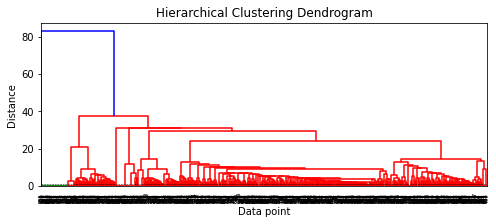

In [ ]:
plt.figure(figsize=(8, 3))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data point')
plt.ylabel('Distance')
dendrogram(Z)
plt.axhline(y=1.0, c='k', ls='--', lw=0.5)

In [ ]:
from scipy.cluster.hierarchy import fcluster
max_dist = 1.0

cluster_labels = fcluster(Z, max_dist, criterion='distance')
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,reviewText,summary,ClusterLabel
0,This phone is ugly and heavy and has a terribl...,Bad reception,156
1,This phone is ugly and heavy and has a terribl...,Bad reception,156
2,I had the Samsung V205 and then I decided to t...,Pretty good phone.. an improvement from my v205,79
3,I had the Samsung V205 and then I decided to t...,Pretty good phone.. an improvement from my v205,79
4,This is the first Samsung phone I have had and...,Not as user friendly as the Motorola V300-,212
...,...,...,...
995,We purchased two of these phones one pink and ...,NOT Good.......,75
996,Returned and defective. Was sold to me as NEW ...,"Watch out for sellers who say ""new"" when it is...",240
997,This is a great phone for anyone who does not ...,Great Phone,2
998,"I like it very much,but delivery is too long",good,75
